In [1]:
import pandas as pd 
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
from functions.common_functions import *

In [2]:
df = pd.read_csv('../data/processed/mannich_scope-descriptors.csv')

In [3]:
## Initial Processing ##

vt = VarianceThreshold()

parameters = df.iloc[:,5:] ## Set parameters to desired columns ##
thres = vt.fit(parameters)
parameters = thres.transform(parameters)

scaled_data = StandardScaler().fit_transform(parameters)

In [4]:
## Elbow Plot ##

num_reactions = len(df)

reducer = umap.UMAP(
    random_state=25,
    min_dist=0,  # Default is 0.1
    n_neighbors=num_reactions-1,  # Default is 15
    n_components=10)

clustering_embedding = reducer.fit_transform(scaled_data)

range_, inertia = get_clusters(clustering_embedding,50)

fig = px.scatter(x=range_, y=inertia,
                labels={'x':'# of Clusters', 'y':'Inertia'},
                template='simple_white'
                )

fig.update_traces(marker=dict(size=17,
                              line=dict(width=2,
                                        color='Black')),
                  selector=dict(mode='markers'))

fig.update_xaxes(mirror=True)
fig.update_yaxes(mirror=True)

fig.update_layout(
    font_size=20,
)

fig.show()

In [5]:
## Get Cluster Labels ##

labels = k_cluster(clustering_embedding,12)
rxn_cluster_df = pd.DataFrame({'Reaction':df['Reaction'],'cluster_label':labels})


In [6]:
## Merge labels to full dataset ##

full_df = pd.read_csv('../data/interim/mannich_database_scope.csv')
full_df = remove_x(full_df,'ee')
full_df_trim = full_df.loc[:,['Reaction','Catalyst_Type','ee']]
full_df_clusters = pd.merge(full_df_trim,rxn_cluster_df,how='inner',on='Reaction')

In [7]:
cat_counts = pd.DataFrame(full_df['Catalyst_Type'].value_counts())
cat_counts = pd.DataFrame({'Catalyst_Type':cat_counts.index,'count':cat_counts['Catalyst_Type']})

In [8]:
## Calculate Generality ##
cats = full_df_clusters['Catalyst_Type'].unique()

cat_list = []
gen_list = []
cluster_list = []
cluster_ee_list = []
avg_ee_list = []
for cat in cats:
    generality, clusters, cluster_ee = calc_generality(full_df_clusters,cat,'Catalyst_Type','ee', full_df_clusters['cluster_label'], 80)
    cat_list.append(cat)
    gen_list.append(generality)
    cluster_list.append(clusters)
    cluster_ee_list.append(cluster_ee)
    avg_ee_list.append(average_ee(cat,'Catalyst_Type',full_df_clusters))

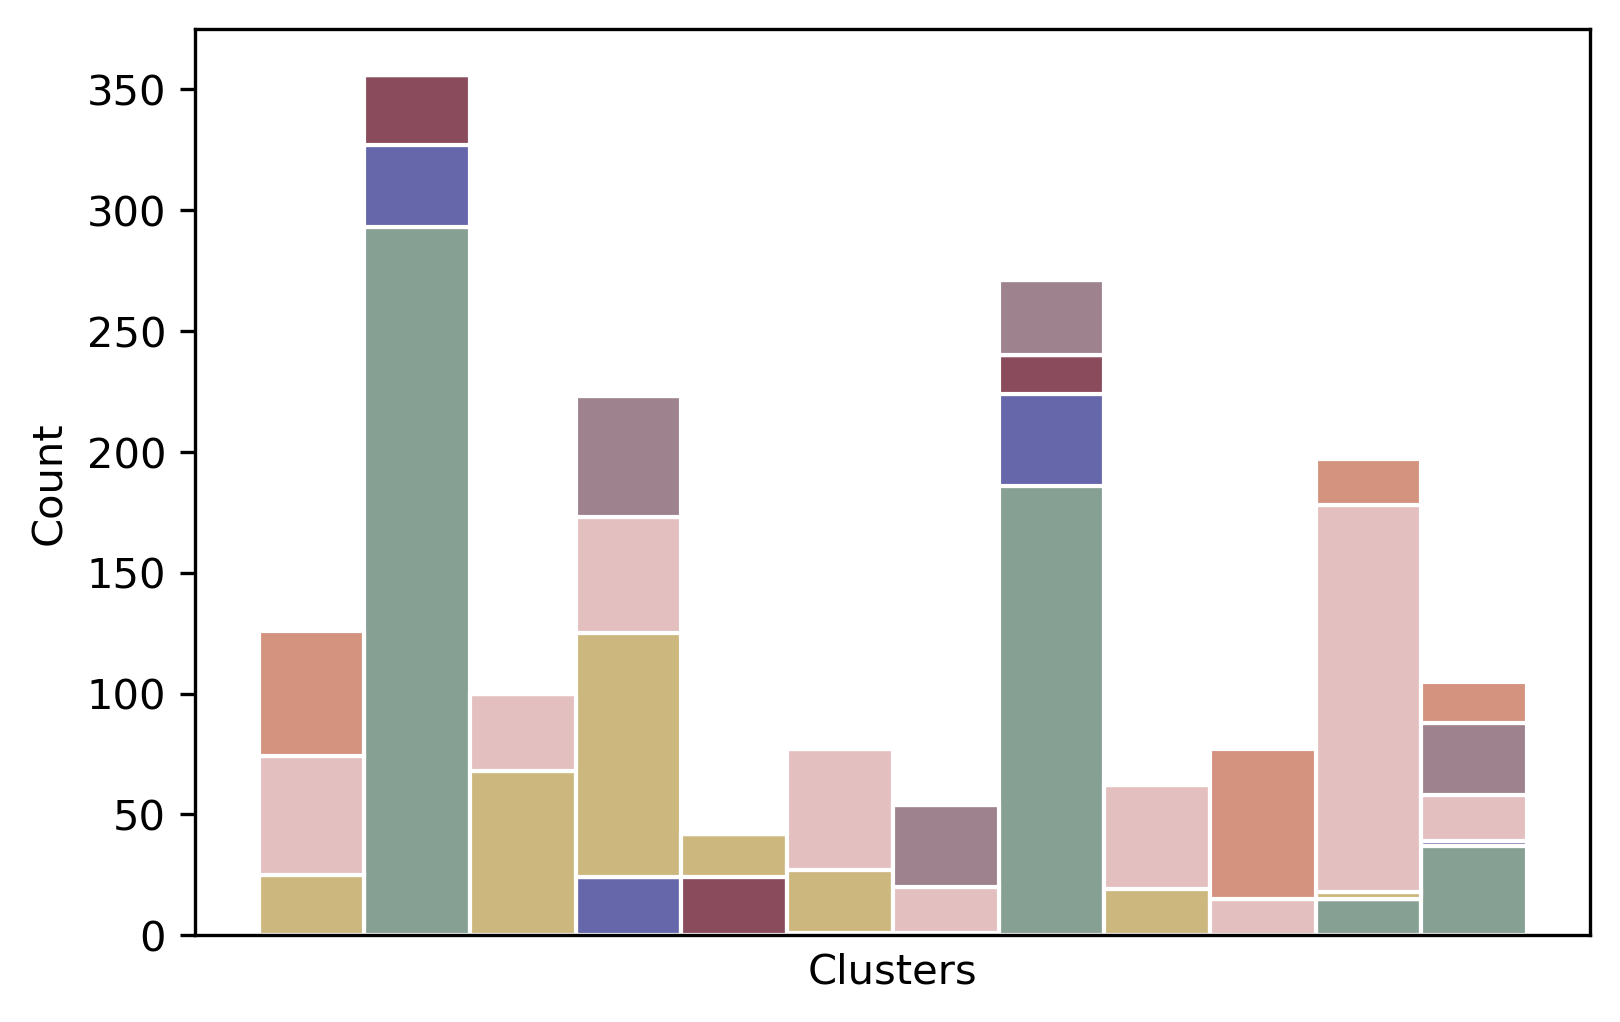

In [9]:
import matplotlib.pyplot as plt
clist = []
for cat in cats:
    var = full_df_clusters[full_df_clusters['Catalyst_Type']==cat]
    clist.append(var.iloc[:,3])

fig, ax = plt.subplots()
fig.set_dpi(300)

plt.hist(clist, 12, stacked=True,label=cats, align='left', edgecolor='white', color=['#86a094','#6667ab','#8a4c5d','#ccb87e','#e3c0bf','#9e838e','#d4937f'])
plt.xticks([])
plt.ylabel('Count')
plt.xlabel('Clusters')
plt.show()

In [11]:
## Plots ##
df_ = pd.DataFrame({'Catalyst_Type':cat_list,'Generality':gen_list,'Average ee/100':np.divide(avg_ee_list,100)}).merge(cat_counts,how='inner',on='Catalyst_Type')
df_['count'] = (df_['count']-min(df_['count']))/(max(df_['count'])-min(df_['count']))
df_ = df_.rename(columns={'count':'Count (Normalized)'})
fig = px.bar(df_, x='Catalyst_Type', y=['Generality','Average ee/100', 'Count (Normalized)'],
                barmode='group',
                labels={'Catalyst_Type':'Catalyst Class', 'count':'Count (Normalized)', 'value':'Value'},
                template='simple_white',
                color_discrete_sequence=[px.colors.qualitative.T10[2],
                px.colors.qualitative.T10[0],
                px.colors.qualitative.T10[3]],
                  width=980, height=720,
                )

fig.update_xaxes(mirror=True)
fig.update_yaxes(mirror=True)

fig.update_layout(
    font_size=20,
    font_family="Arial",
)

fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=1.01,
        xanchor="left",
        x=0.01,
        orientation='h',
    ),
    legend_title_text='',
)


fig.show()


In [12]:
# Align Clusters
thio = pd.DataFrame({'Cluster':cluster_list[4],'Thiourea':cluster_ee_list[4]})
sec = pd.DataFrame({'Cluster':cluster_list[0],'Secondary Amine':cluster_ee_list[0]})
cinch = pd.DataFrame({'Cluster':cluster_list[3], 'Cinchona Alkaloid':cluster_ee_list[3]})
clusters = pd.DataFrame({'Cluster':np.unique(labels)})
join_df = pd.merge(pd.merge(pd.merge(clusters,thio,how='left', on='Cluster'),sec,how='left',on='Cluster'),cinch, how='left', on='Cluster')
join_df = join_df.sort_values('Secondary Amine')
join_df['Cluster'] = range(0,12)

fig = px.bar(join_df, x='Cluster',y=['Thiourea','Secondary Amine'],
                labels={'x':'Cluster', 'y':'Average ee', 'value':'Average ee'},
                template='simple_white',
                barmode='group',
                width=980, height=720,
                color_discrete_sequence=[px.colors.qualitative.T10[2],px.colors.qualitative.T10[0], px.colors.qualitative.T10[9]]
                )


fig.update_traces(marker=dict(size=17,
                              line=dict(width=2,
                                        color='Black')),
                  selector=dict(mode='markers'))

fig.update_xaxes(mirror=True)
fig.update_yaxes(mirror=True)

fig.update_layout(
    font_size=20,
    font_family="Arial",
)

fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=1.01,
        xanchor="left",
        x=0.01,
        orientation='h',
    ),
    legend_title_text=''
)

fig.update_xaxes(dtick=1)

fig.update_yaxes(range=[50,100])

fig.add_hline(y=80, line_width=3, line_dash="dash", line_color="black", annotation_text="Success Cutoff", 
              annotation_position="bottom right")
fig.update_layout(showlegend=False)
fig.show()